## Setup

In [1]:
import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [26]:
import os
import pickle
import string
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import random

from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from alive_progress import alive_bar
from scipy import spatial

In [3]:
nltk.download("stopwords")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joycelyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
CLEAN_DATA_PATH = os.path.join("..", "data", "healthhub_small_clean")

CLEANED_CHUNK_ID_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_chunk_id_list_small_clean.pkl"
)
CLEANED_SOURCE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_source_list_small_clean.pkl"
)
CLEANED_DOMAIN_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_domain_list_small_clean.pkl"
)
CLEANED_TITLE_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_title_list_small_clean.pkl"
)
CLEANED_CONTRIBUTOR_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_contributor_list_small_clean.pkl"
)
CLEANED_CONTENT_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_content_list_small_clean.pkl"
)
CLEANED_CATEGORY_LIST_PATH = os.path.join(
    CLEAN_DATA_PATH, "healthhub_category_list_small_clean.pkl"
)
# CLEANED_EMBEDDING_LIST_PATH = os.path.join(
#     CLEAN_DATA_PATH,
#     f"healthhub_{MODEL_NAME}_{POOLING_STRATEGY}_embeddings_small_clean.parquet",
# )

In [64]:
def remove_punctuation(text):
    """Removes punctuation characters from a string.

    Args:
        text: The string to remove punctuation from.

    Returns:
        The string with punctuation characters removed.
    """
    # Create a set of punctuation characters
    punctuations = set("’" + "—" + string.punctuation)
    # Remove punctuation from the text
    no_punct_text = "".join([char for char in text if char not in punctuations])
    return no_punct_text


def preprocess_and_vectorize(text, word_tokenize, model):
    """Preprocesses text, creates vector, and returns it."""
    preprocessed_text = word_tokenize(text)
    vec = model.infer_vector(preprocessed_text)
    return vec

## Load metadata

In [6]:
with open(CLEANED_CHUNK_ID_LIST_PATH, "rb") as file:
    loaded_chunk_id = pickle.load(file)  # list of chunk ids

with open(CLEANED_SOURCE_LIST_PATH, "rb") as file:
    loaded_source = pickle.load(file)  # list of hyperlinks

with open(CLEANED_DOMAIN_LIST_PATH, "rb") as file:
    loaded_domain = pickle.load(file)  # website domain

with open(CLEANED_TITLE_LIST_PATH, "rb") as file:
    loaded_title = pickle.load(file)  # list of titles each chunk belongs to

with open(CLEANED_CONTRIBUTOR_LIST_PATH, "rb") as file:
    loaded_contributor = pickle.load(file)  # list of contributors

with open(CLEANED_CONTENT_LIST_PATH, "rb") as file:
    loaded_content = pickle.load(file)  # list of chunks of contents

with open(CLEANED_CATEGORY_LIST_PATH, "rb") as file:
    loaded_category = pickle.load(file)  # list of categories

## Data Preprocessing

### Combine chunks of same articles

In [54]:
CONTRIBUTOR: str = "Health Promotion Board"
CATEGORY: str = "live-healthy"

df = pd.DataFrame(
    {
        "chunk_id": loaded_chunk_id,
        "doc_source": loaded_source,
        "doc_domain": loaded_domain,
        "doc_title": loaded_title,
        "contributor": loaded_contributor,
        "text": loaded_content,
        "category": loaded_category,
    }
)

df = df[df["contributor"] == CONTRIBUTOR].reset_index(drop=True)
df = df[df["category"] == CATEGORY].reset_index(drop=True)

print(df.shape)
df.head()

(2008, 7)


,chunk_id,doc_source,doc_domain,doc_title,contributor,text,category
0,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_1,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,Building Supportive Network Family Friends Hum...,live-healthy
1,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_2,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,"Therefore , advisable number strong relationsh...",live-healthy
2,web_crawl_c3d4d37b-eb92-5349-9d5c-81f2e38e1cfb_3,https://www.healthhub.sg/live-healthy/building...,healthhub.sg,buildingasupportivenetwork,Health Promotion Board,Pick new hobby get know like-minded people enj...,live-healthy
3,web_crawl_2b12fdec-76a5-55a7-ad1e-d0ae2b29c864_1,https://www.healthhub.sg/live-healthy/mental_h...,healthhub.sg,mental_health_emotional_intelligence_pdf,Health Promotion Board,Develop Emotional Intelligence Give Mental Wel...,live-healthy
4,web_crawl_2b12fdec-76a5-55a7-ad1e-d0ae2b29c864_2,https://www.healthhub.sg/live-healthy/mental_h...,healthhub.sg,mental_health_emotional_intelligence_pdf,Health Promotion Board,Learn recognise early signs stress different e...,live-healthy


In [55]:
# Combining chunks from the same doc_source

df["combined_text"] = None

for source in df["doc_source"].unique():
    combined_text = " ".join(df.query("doc_source == @source")["text"].values)
    indices = df.query("doc_source == @source").index.values
    df.loc[indices, "combined_text"] = combined_text

df.tail()

,chunk_id,doc_source,doc_domain,doc_title,contributor,text,category,combined_text
2003,web_crawl_49964963-3f83-5d82-9495-b130cc1e629f_3,https://www.healthhub.sg/live-healthy/what-a-w...,healthhub.sg,what-a-weaning-baby-needs-for-strong-immunity,Health Promotion Board,Plain full cream milk given toddlers 12 months...,live-healthy,Weaning Baby Needs Strong Immunity baby reache...
2004,web_crawl_49964963-3f83-5d82-9495-b130cc1e629f_4,https://www.healthhub.sg/live-healthy/what-a-w...,healthhub.sg,what-a-weaning-baby-needs-for-strong-immunity,Health Promotion Board,"notice symptoms , stop feeding baby food seek ...",live-healthy,Weaning Baby Needs Strong Immunity baby reache...
2005,web_crawl_be20701c-e418-544a-bd58-6c97c436a128_1,https://www.healthhub.sg/live-healthy/warnings...,healthhub.sg,warningsignsof_dementia,Health Promotion Board,Warning Signs Dementia Dementia normal part ag...,live-healthy,Warning Signs Dementia Dementia normal part ag...
2006,web_crawl_be20701c-e418-544a-bd58-6c97c436a128_2,https://www.healthhub.sg/live-healthy/warnings...,healthhub.sg,warningsignsof_dementia,Health Promotion Board,become lost confused get around neighbourhood ...,live-healthy,Warning Signs Dementia Dementia normal part ag...
2007,web_crawl_be20701c-e418-544a-bd58-6c97c436a128_3,https://www.healthhub.sg/live-healthy/warnings...,healthhub.sg,warningsignsof_dementia,Health Promotion Board,​Withdrawal Work Social Activities Persons dem...,live-healthy,Warning Signs Dementia Dementia normal part ag...


### Unique articles

In [65]:
doc_source_list = []
combined_text_list = []
doc_title_list = []

for source in df["doc_source"].unique():
    combined_text = df[df["doc_source"] == source]["combined_text"].iloc[0]
    doc_title = df[df["doc_source"] == source]["doc_title"].iloc[0]
    doc_source_list.append(source)
    combined_text_list.append(combined_text)
    doc_title_list.append(doc_title)

df_articles = pd.DataFrame(
    {
        "doc_source": doc_source_list,
        "doc_title": doc_title_list,
        "article_text": combined_text_list,
    }
)
df_articles["article_text_clean"] = df_articles["article_text"].apply(
    remove_punctuation
)

df_articles.tail()

,doc_source,doc_title,article_text,article_text_clean
583,https://www.healthhub.sg/live-healthy/slip-ups...,slip-ups-dos-and-donts,Slip-Ups : Dos Dont 's Slipped picked cigarett...,SlipUps Dos Dont s Slipped picked cigarette ...
584,https://www.healthhub.sg/live-healthy/is-my-ba...,is-my-baby%27s-spit-up-normal,Q & : Baby 's Spit-Up Normal ? Find baby spits...,Q Baby s SpitUp Normal Find baby spits s l...
585,https://www.healthhub.sg/live-healthy/awkward_...,awkward_turtle,Make Friends Better Mental Well-being Overcome...,Make Friends Better Mental Wellbeing Overcome ...
586,https://www.healthhub.sg/live-healthy/what-a-w...,what-a-weaning-baby-needs-for-strong-immunity,Weaning Baby Needs Strong Immunity baby reache...,Weaning Baby Needs Strong Immunity baby reache...
587,https://www.healthhub.sg/live-healthy/warnings...,warningsignsof_dementia,Warning Signs Dementia Dementia normal part ag...,Warning Signs Dementia Dementia normal part ag...


### word count of article text

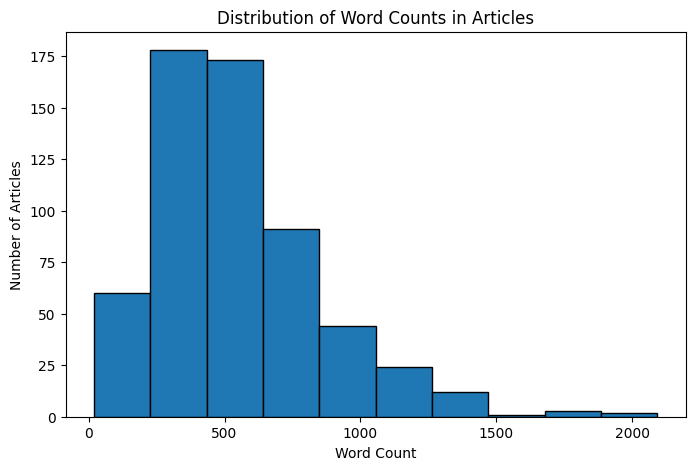

In [124]:
# Apply the remove_punctuation function to the article_text column
df_articles["article_text_clean"] = df_articles["article_text"].apply(
    remove_punctuation
)

# Now calculate word count without punctuation
df_articles["word_count"] = df_articles["article_text_clean"].apply(
    lambda x: len(list(filter(None, x.split(" "))))
)

# Plot histogram
plt.figure(figsize=(8, 5))

plt.hist(df_articles["word_count"], bins=10, edgecolor="black")  # Adjust bins as needed
plt.xlabel("Word Count")
plt.ylabel("Number of Articles")
plt.title("Distribution of Word Counts in Articles")

plt.show()

In [17]:
df_articles["word_count"].describe()

count     588.000000
mean      546.656463
std       311.207547
min        19.000000
25%       342.750000
50%       485.000000
75%       702.250000
max      2093.000000
Name: word_count, dtype: float64

## Doc2vec training

In [125]:
tagged_data = [
    TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)])
    for i, _d in enumerate(list(df_articles["article_text_clean"]))
]
tagged_data[:5]

[TaggedDocument(words=['building', 'supportive', 'network', 'family', 'friends', 'human', 'beings', 'thrive', 'alone', 'need', 'family', 'friends', 'pillars', 'support', 'especially', 'difficult', 'times', 'strong', 'network', 'supportive', 'family', 'friends', 'helps', 'enhance', 'mental', 'wellbeing', 'learn', 'importance', 'supportive', 'network', 'maintain', 'build', 'one', '\u200bas', 'saying', 'goes', 'no', 'man', 'island', 'everyone', 'needs', 'companionship', 'shoulder', 'lean', 'important', 'surround', 'family', 'friends', 'support', 'comfort', 'times', 'joy', 'distress', 'studies', 'shown', 'supportive', 'relationships', 'strong', 'protective', 'factor', 'mental', 'illnesses', 'helps', 'increase', 'mental', 'wellbeing', 'mean', 'supportive', 'network', 'family', 'friends', 'supportive', 'network', 'family', 'friends', 'mean', 'one', 'seek', 'make', 'many', 'friends', 'possible', 'sake', 'instead', 'one', 'strive', 'focus', 'several', 'important', 'relationships', 'handful', '

In [151]:
import logging

logging.basicConfig(
    format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
)

vec_size = 25
window = 5
alpha = 0.025
max_epochs = 100

model = Doc2Vec(
    vector_size=vec_size,  # Dimensionality of the document vectors
    window=window,  # Maximum distance between the current and predicted word within a sentence
    alpha=alpha,  # initial learning rate
    min_alpha=0.00025,  # Learning rate will linearly drop to `min_alpha` as training progresses.
    min_count=5,  # Ignores all words with total frequency lower than this
    dm=1,  # ‘distributed memory’ (PV-DM): preserves the word order in a document
    epochs=max_epochs,
)  # Number of training epochs

model.build_vocab(tagged_data)

# #Gradually decrease the learning rate during training to potentially improve convergence and stability.
# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     model.train(tagged_data,
#                 total_examples=model.corpus_count,
#                 epochs=model.epochs)
#     # decrease the learning rate in each epoch
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

model.save(r"..\artifacts\outputs\d2v.model")
print("Model Saved")

2024-06-14 10:05:11,014 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d25,n5,w5,mc5,s0.001,t3>', 'datetime': '2024-06-14T10:05:11.014331', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'created'}
2024-06-14 10:05:11,015 : INFO : collecting all words and their counts
2024-06-14 10:05:11,016 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-06-14 10:05:11,086 : INFO : collected 20849 word types and 588 unique tags from a corpus of 588 examples and 320739 words
2024-06-14 10:05:11,087 : INFO : Creating a fresh vocabulary
2024-06-14 10:05:11,117 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 6734 unique words (32.30% of original 20849, drops 14115)', 'datetime': '2024-06-14T10:05:11.117325', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42

Model Saved


## Finding similar documents

### Matching documents in training set

In [17]:
# load trained model
model = Doc2Vec.load("d2v.model")

# to find most similar doc using tags
similar_doc = model.dv.most_similar("1")
print(similar_doc)

[('127', 0.6889229416847229), ('286', 0.6349616050720215), ('85', 0.6268700957298279), ('57', 0.6265912652015686), ('232', 0.6070023775100708), ('585', 0.6036197543144226), ('247', 0.5982409119606018), ('454', 0.5766449570655823), ('81', 0.5567885041236877), ('410', 0.5481607913970947)]


In [21]:
# with threshold
th = 0.6
similar_doc_th = [item for item in similar_doc if item[1] > th]
print(f"before th: {len(similar_doc)}")
print(f"after th: {len(similar_doc_th)}")

df = pd.DataFrame(similar_doc_th, columns=["doc_index", "Similarity Score"])
df["ref_to"] = "1"
df["article_text"] = df["doc_index"].apply(lambda x: combined_text_list[int(x)])
df

before th: 10
after th: 6


,doc_index,Similarity Score,ref_to,article_text
0,127,0.688923,1,6 Ways Improve Social Skills Increase Social I...
1,286,0.634962,1,7 Easy Tips Better Mental Well-being Mental we...
2,85,0.626870,1,Positive Mental Well-being—The Foundation Flou...
3,57,0.626591,1,6 Ways Develop Resilience Better Mental Health...
4,232,0.607002,1,Building Resilience Child ’ protect children l...
5,585,0.603620,1,Make Friends Better Mental Well-being Overcome...


### Looping across all docs in training set

model.dv.most_similar defaults topn=10

In [22]:
th = 0.8

df_similarity_search = pd.DataFrame(
    columns=["doc_index", "similarity_score", "ref_to", "doc_index_article_text"]
)

for i in range(len(tagged_data)):
    similar_doc = model.dv.most_similar(f"{i}")
    similar_doc_th = [item for item in similar_doc if item[1] > th]
    df_docs = pd.DataFrame(similar_doc_th, columns=["doc_index", "similarity_score"])
    df_docs["ref_to"] = str(i)
    df_docs["doc_index_article_text"] = df_docs["doc_index"].apply(
        lambda x: combined_text_list[int(x)]
    )
    df_similarity_search = pd.concat([df_similarity_search, df_docs], ignore_index=True)

# df_similarity_search.to_csv("test_output.csv")
df_similarity_search

,doc_index,similarity_score,ref_to,doc_index_article_text
0,11,0.899221,2,Meal Ideas : Month 8 Meal ideas 8-month-old ba...
1,32,0.870668,2,Meal Ideas : Month 11 Meal ideas 11-month-old ...
2,539,0.859989,2,7-month-baby Diet : Authoritative Guide Expert...
3,48,0.840869,2,Meal Ideas : Month 10 Meal ideas 10-month-old ...
4,196,0.822565,2,Meal Ideas : Month 12 Meal ideas 12-month-old ...
...,...,...,...,...
215,229,0.835233,558,Child ’ Fifth Year : Bite-sized Reminders Mumm...
216,505,0.838504,577,Much Eat ? Perfecting Portions Knowing 's reas...
217,229,0.811269,583,Child ’ Fifth Year : Bite-sized Reminders Mumm...
218,132,0.809607,583,Child ’ Sixth Year : Bite-sized Reminders Mumm...


### Applying saved model on documents

In [ ]:
# load trained model
model = Doc2Vec.load("d2v.model")

In [29]:
# similarity between 2 docs
doc1 = df_articles["article_text"].iloc[505]
doc2 = df_articles["article_text"].iloc[577]

preprocessed_doc1 = word_tokenize(doc1)
preprocessed_doc2 = word_tokenize(doc2)

vec1 = model.infer_vector(preprocessed_doc1)
vec2 = model.infer_vector(preprocessed_doc2)

cos_similarity = 1 - spatial.distance.cosine(vec1, vec2)
cos_similarity

0.830321998422667

In [30]:
# similarity between 2 docs in training set, using tag number
model.docvecs.similarity(2, 1)

0.2231158

In [31]:
# looping across all training set docs and calculate pair-wise similarity
num_documents = 588
results = []

# Iterate through all document pairs (i, j) where i < j
for i in range(num_documents):
    for j in range(i, num_documents):  # Now j starts from i (inclusive)
        doc_pair = (i, j)
        similarity_score = model.docvecs.similarity(i, j)
        results.append([doc_pair, similarity_score])

results_df = pd.DataFrame(results, columns=["doc_pair", "similarity_score"])
# results_df.to_csv("results_output.csv")
results_df

,doc_pair,similarity_score
0,"(0, 0)",1.000000
1,"(0, 1)",0.504982
2,"(0, 2)",0.212951
3,"(0, 3)",0.255023
4,"(0, 4)",0.253890
...,...,...
173161,"(585, 586)",0.194607
173162,"(585, 587)",0.258753
173163,"(586, 586)",1.000000
173164,"(586, 587)",0.183613


## Evaluation

In [ ]:
def pairwise_similarity(matrix_of_vectors):
    """
    Computes cosine similarities for between all vectors, extremely useful for comparing
    similarities between embeddings when doing deep embedding learning.

    input:
        matrix_of_vectors: tensor with shape (n_vectors, vector_size)

    output:
        similarities : tensor with shape (n_vector, n_vectors)
    Each row[i, j] is the similarity of the ith element against the jth vector, eg,
    row[0,0] is 1 and row[0,42] is the similarity between the first
    element in the input and the 43th element in the input.
    """

    dot_product = np.dot(matrix_of_vectors, matrix_of_vectors.T)
    norms = np.linalg.norm(matrix_of_vectors, axis=1)
    similarities = dot_product / np.outer(norms, norms)

    return similarities


# Function to darken a hex color
def darken_hex_color(hex_color, factor=0.7):
    # Ensure factor is between 0 and 1
    factor = max(0, min(1, factor))

    # Convert hex color to RGB
    r = int(hex_color[1:3], 16)
    g = int(hex_color[3:5], 16)
    b = int(hex_color[5:7], 16)

    # Darken the color
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)

    # Convert RGB back to hex
    darkened_color = f"#{r:02x}{g:02x}{b:02x}".upper()

    return darkened_color

In [158]:
# load trained model
# model= Doc2Vec.load("d2v.model")
model = Doc2Vec.load(r"..\artifacts\outputs\d2v.model")

df_articles["doc2vec_vector"] = df_articles["article_text"].apply(
    lambda x: preprocess_and_vectorize(x, word_tokenize, model)
)

ground_df = pd.read_excel(
    os.path.join(
        "..", "data", "Synapxe Content Prioritisation - Live Healthy_020724.xlsx"
    ),
    sheet_name="All Live Healthy",
    index_col=False,
)

# merge ground truth and df_articles dataframes
merge_df = pd.merge(
    df_articles, ground_df, how="left", left_on="doc_source", right_on="URL"
)
merge_df = merge_df[[*df_articles.columns, "Combine Group ID"]]
merge_df = merge_df[merge_df["Combine Group ID"].notna()]
merge_df = merge_df.sort_values(by="Combine Group ID").reset_index(drop=True)
merge_df["Combine Group ID"] = merge_df["Combine Group ID"].astype(int)
merge_df.shape

2024-06-14 10:23:13,543 : INFO : loading Doc2Vec object from ..\artifacts\outputs\d2v.model
2024-06-14 10:23:13,560 : INFO : loading dv recursively from ..\artifacts\outputs\d2v.model.dv.* with mmap=None
2024-06-14 10:23:13,562 : INFO : loading wv recursively from ..\artifacts\outputs\d2v.model.wv.* with mmap=None
2024-06-14 10:23:13,563 : INFO : setting ignored attribute cum_table to None
2024-06-14 10:23:13,614 : INFO : Doc2Vec lifecycle event {'fname': '..\\artifacts\\outputs\\d2v.model', 'datetime': '2024-06-14T10:23:13.614333', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'loaded'}


(187, 7)

In [159]:
start = 0
end = 20

article_titles = merge_df.loc[:, "doc_title"].tolist()
cutoff_article_titles = article_titles[start:end]

# filter on articles in list
df_articles_filtered = df_articles[df_articles["doc_title"].isin(cutoff_article_titles)]
# reorder rows according to list
df_articles_filtered["doc_title"] = pd.Categorical(
    df_articles_filtered["doc_title"], categories=cutoff_article_titles, ordered=True
)
df_articles_filtered = df_articles_filtered.sort_values(by="doc_title").reset_index(
    drop=True
)

vector_series = df_articles_filtered["doc2vec_vector"]
vectors = np.vstack(vector_series)
similarities = pairwise_similarity(vectors)
similarities.shape

C:\Users\Joycelyn\AppData\Local\Temp\ipykernel_14832\1209082788.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_articles_filtered['doc_title'] = pd.Categorical(df_articles_filtered['doc_title'], categories=cutoff_article_titles, ordered=True)


(20, 20)

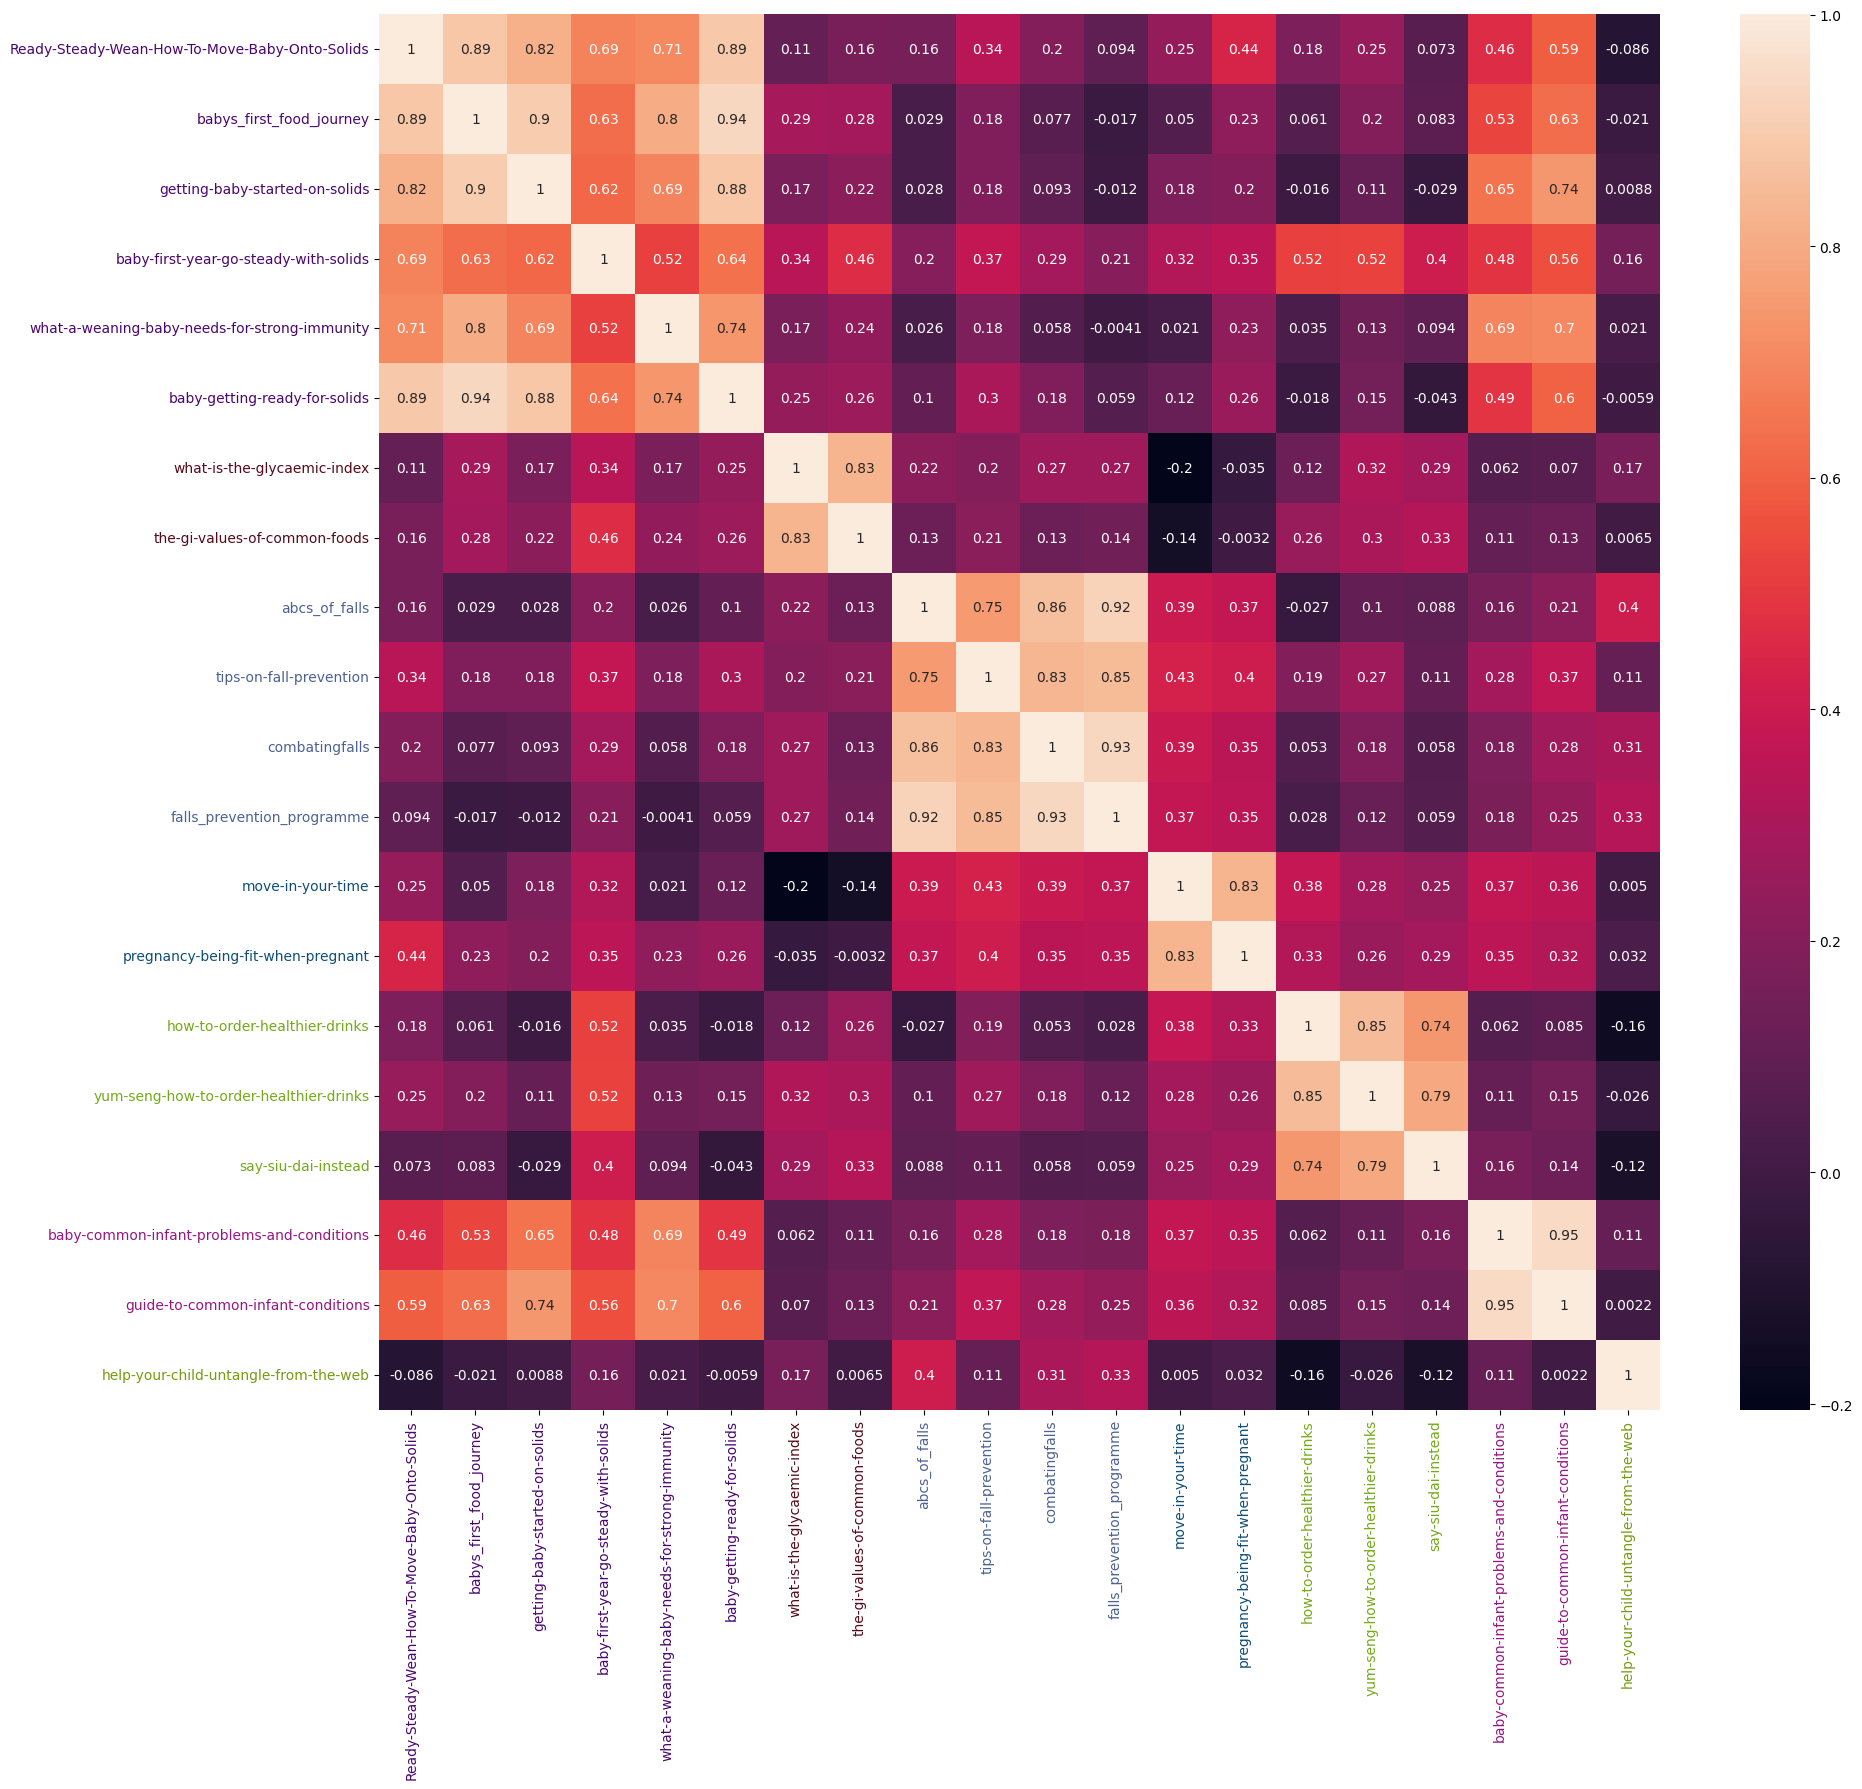

In [160]:
hexadecimal_alphabets = "0123456789ABCDEF"
ground_truth_cluster_ids = merge_df.iloc[start:end]["Combine Group ID"].unique()

colours = {
    id: darken_hex_color(
        "#" + "".join([random.choice(hexadecimal_alphabets) for _ in range(6)])
    )
    for id in ground_truth_cluster_ids
}

plt.figure(figsize=(20, 18))  # Adjust figure size as desired
ax = sns.heatmap(
    similarities,
    xticklabels=cutoff_article_titles,
    yticklabels=cutoff_article_titles,
    annot=True,
    fmt=".2g",
)  # Customize colormap if needed

for x_tick_label, y_tick_label in zip(
    ax.axes.get_xticklabels(), ax.axes.get_yticklabels()
):

    ground_truth_cluster_id = (
        merge_df[merge_df["doc_title"] == y_tick_label.get_text()]["Combine Group ID"]
        .values[0]
        .astype(int)
    )
    colour = colours[ground_truth_cluster_id]
    y_tick_label.set_color(colour)
    x_tick_label.set_color(colour)

plt.tight_layout()
plt.show()

## Output for visualisation

In [161]:
model = Doc2Vec.load(r"..\artifacts\outputs\d2v.model")

df_articles["doc2vec_vector"] = df_articles["article_text"].apply(
    lambda x: preprocess_and_vectorize(x, word_tokenize, model)
)

ground_df = pd.read_excel(
    os.path.join(
        "..", "data", "Synapxe Content Prioritisation - Live Healthy_020724.xlsx"
    ),
    sheet_name="All Live Healthy",
    index_col=False,
)

# merge ground truth and df_articles dataframes
merge_df = pd.merge(
    df_articles, ground_df, how="left", left_on="doc_source", right_on="URL"
)
merge_df = merge_df[[*df_articles.columns, "Combine Group ID"]]
merge_df = merge_df[merge_df["Combine Group ID"].notna()]
merge_df = merge_df.sort_values(by="Combine Group ID").reset_index(drop=True)
merge_df["Combine Group ID"] = merge_df["Combine Group ID"].astype(int)
merge_df.shape

2024-06-14 10:41:18,696 : INFO : loading Doc2Vec object from ..\artifacts\outputs\d2v.model
2024-06-14 10:41:18,710 : INFO : loading dv recursively from ..\artifacts\outputs\d2v.model.dv.* with mmap=None
2024-06-14 10:41:18,711 : INFO : loading wv recursively from ..\artifacts\outputs\d2v.model.wv.* with mmap=None
2024-06-14 10:41:18,711 : INFO : setting ignored attribute cum_table to None
2024-06-14 10:41:18,763 : INFO : Doc2Vec lifecycle event {'fname': '..\\artifacts\\outputs\\d2v.model', 'datetime': '2024-06-14T10:41:18.763358', 'gensim': '4.3.2', 'python': '3.12.3 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:42:21) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.22631-SP0', 'event': 'loaded'}


(187, 7)

In [174]:
article_titles = merge_df.loc[:, "doc_title"].tolist()

# filter on articles in list
df_articles_filtered = df_articles[df_articles["doc_title"].isin(article_titles)]
df_articles_filtered.shape

# reorder rows according to list
df_articles_filtered["doc_title"] = pd.Categorical(
    df_articles_filtered["doc_title"], categories=article_titles, ordered=True
)
df_articles_filtered = df_articles_filtered.sort_values(by="doc_title").reset_index(
    drop=True
)

# similarity matrix
vector_series = df_articles_filtered["doc2vec_vector"]
vectors = np.vstack(vector_series)
similarities = pairwise_similarity(vectors)
similarities.shape

C:\Users\Joycelyn\AppData\Local\Temp\ipykernel_14832\1939209420.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_articles_filtered['doc_title'] = pd.Categorical(df_articles_filtered['doc_title'], categories=article_titles, ordered=True)


(187, 187)

In [178]:
similarities_df = pd.DataFrame(similarities)
similarities_df.columns = article_titles
similarities_df.index = article_titles
similarities_df

,Ready-Steady-Wean-How-To-Move-Baby-Onto-Solids,babys_first_food_journey,getting-baby-started-on-solids,baby-first-year-go-steady-with-solids,what-a-weaning-baby-needs-for-strong-immunity,baby-getting-ready-for-solids,what-is-the-glycaemic-index,the-gi-values-of-common-foods,abcs_of_falls,tips-on-fall-prevention,...,keep-fit-while-waiting-in-line,youre-movable-in-your-cubicle,walk-the-malls-shop-till-you-drop-kilos,10k-ok-how-to-move-more-in-everyday-life,the-nudge-to-budge-why-you-should-step-out-of-that-chair,just-keep-moving-just-keep-moving,get-up-and-go---tips-to-get-started-on-your-exercise-journey,5_reasons_to_keep_exercising,4-things-you-can-do-to-keep-your-teens-sober,smoking-alcohol-and-drugs---why-teens-get-hooked-on-this-triple-threat
Ready-Steady-Wean-How-To-Move-Baby-Onto-Solids,1.000000,0.885000,0.817541,0.686088,0.705434,0.890437,0.105976,0.164354,0.161706,0.342034,...,0.051614,-0.148510,-0.074886,-0.271740,-0.182714,-0.060552,0.033632,-0.098356,0.105000,-0.000428
babys_first_food_journey,0.885000,1.000000,0.896825,0.629394,0.804999,0.938491,0.292516,0.284270,0.028563,0.183473,...,-0.196440,-0.316015,-0.055183,-0.436183,-0.387570,-0.170398,-0.081434,-0.212367,0.143919,0.024938
getting-baby-started-on-solids,0.817541,0.896825,1.000000,0.616904,0.692317,0.884099,0.167683,0.222886,0.027625,0.183833,...,0.029876,-0.260564,0.059760,-0.369994,-0.347019,-0.133101,-0.035471,-0.284256,0.085425,0.154831
baby-first-year-go-steady-with-solids,0.686088,0.629394,0.616904,1.000000,0.519252,0.640130,0.342593,0.464432,0.202818,0.372020,...,0.191434,0.058609,0.233720,0.073969,0.203431,0.233910,0.223608,0.167202,0.190809,0.153731
what-a-weaning-baby-needs-for-strong-immunity,0.705434,0.804999,0.692317,0.519252,1.000000,0.736460,0.167644,0.235205,0.025986,0.180737,...,-0.282249,-0.408792,-0.246674,-0.494680,-0.376902,-0.180182,-0.096070,-0.141617,0.123166,0.064073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
just-keep-moving-just-keep-moving,-0.060552,-0.170398,-0.133101,0.233910,-0.180182,-0.143947,0.063434,0.068872,0.166083,0.095850,...,0.527887,0.527498,0.658825,0.664528,0.672092,1.000000,0.746462,0.625565,0.077402,0.019154
get-up-and-go---tips-to-get-started-on-your-exercise-journey,0.033632,-0.081434,-0.035471,0.223608,-0.096070,-0.113924,0.130323,-0.056900,0.409307,0.341623,...,0.541045,0.593245,0.599317,0.712487,0.671199,0.746462,1.000000,0.682144,0.104483,0.105034
5_reasons_to_keep_exercising,-0.098356,-0.212367,-0.284256,0.167202,-0.141617,-0.249936,0.094953,-0.002044,0.356782,0.093128,...,0.527608,0.654081,0.436194,0.618801,0.757376,0.625565,0.682144,1.000000,0.247587,0.044843
4-things-you-can-do-to-keep-your-teens-sober,0.105000,0.143919,0.085425,0.190809,0.123166,0.158597,0.066801,0.037412,0.183016,0.096727,...,-0.002634,0.242025,-0.006176,0.165064,0.319447,0.077402,0.104483,0.247587,1.000000,0.707234


In [180]:
similarities_df.to_csv(r"..\artifacts\outputs\d2v_similarities_matrix.csv")

## End